# import

In [0]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import time
import os
import copy
from torchvision import datasets, models, transforms
from __future__ import print_function
import torchsummary
import torchvision.models as models

In [2]:

print(torch.__version__)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_properties('cuda'))



1.1.0
Tesla K80
_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


# inisilize


In [0]:
batch_size =256
num_class =10
num_epochs = 25
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# dataset

In [5]:
train_dataset = torchvision.datasets.CIFAR10('./MNIST', train=True, transform=transforms.ToTensor() , target_transform=None, download=True)
test_dataset = torchvision.datasets.CIFAR10('./MNIST', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)



0it [00:00, ?it/s]

170500096it [00:06, 27801339.26it/s]                               


Files already downloaded and verified


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)


In [0]:
dataloaders ={'train':train_loader,'test':test_loader}

In [8]:
one_train_batch_imgs,one_train_batch_lbls = next(iter(train_loader))
print(one_train_batch_imgs.shape)
print(one_train_batch_lbls)

torch.Size([256, 3, 32, 32])
tensor([0, 5, 4, 2, 6, 6, 9, 5, 2, 5, 2, 1, 6, 6, 6, 6, 2, 9, 6, 8, 1, 4, 5, 4,
        7, 2, 0, 4, 0, 8, 5, 7, 3, 8, 7, 7, 4, 7, 3, 9, 0, 2, 4, 0, 0, 0, 0, 4,
        9, 8, 6, 6, 3, 1, 2, 7, 1, 4, 8, 1, 8, 5, 1, 0, 2, 5, 9, 7, 9, 7, 6, 7,
        5, 3, 9, 2, 9, 8, 5, 3, 6, 4, 5, 9, 9, 7, 4, 8, 1, 6, 1, 1, 5, 7, 2, 2,
        9, 3, 5, 2, 1, 9, 0, 9, 5, 9, 6, 4, 6, 5, 7, 9, 8, 5, 4, 8, 0, 5, 7, 3,
        0, 4, 2, 7, 3, 8, 5, 5, 4, 1, 3, 3, 7, 6, 1, 6, 8, 7, 7, 6, 9, 1, 7, 6,
        3, 1, 4, 6, 4, 0, 6, 0, 0, 9, 4, 3, 4, 1, 2, 3, 3, 0, 3, 5, 5, 7, 6, 9,
        0, 9, 1, 7, 4, 0, 8, 5, 5, 1, 2, 8, 9, 4, 4, 6, 2, 1, 6, 5, 0, 8, 5, 8,
        1, 9, 7, 1, 6, 3, 2, 8, 9, 7, 0, 6, 3, 0, 0, 8, 0, 3, 9, 9, 4, 0, 8, 4,
        9, 9, 9, 7, 9, 4, 4, 1, 7, 2, 9, 7, 9, 8, 2, 8, 0, 2, 8, 6, 2, 0, 9, 6,
        8, 1, 1, 2, 7, 6, 8, 6, 8, 5, 4, 8, 7, 6, 8, 0])


In [0]:
#  for batch_number, (images,labels) in enumerate (train_loader):
  #  print(batch_number,images.shape)


# model

In [0]:
base = models.resnet18(pretrained=True).to(device)

layers = list(base.children())

l1 = nn.Sequential(*layers[:-5])
# print(l1)

l2 = nn.Sequential(*layers[5])
# print(l2)

l3 = nn.Sequential(*layers[6])
# print(l3)

l4 = nn.Sequential(*layers[7:9])
# print(l4)

l5 = nn.Sequential(layers[9])
# print(l5)

In [0]:
def vis(imgs, idx):
    img = imgs[idx,...].abs().sum(1).squeeze(0)
    img = np.moveaxis(img.cpu().detach().numpy(), 0, -1)
    plt.imshow(img, interpolation='bilinear')
    # plt.Show()

In [135]:
imgs, lbls = next(iter(dataloaders['train']))
imgs = imgs.to(device)
lbls = lbls.to(device)

idx = torch.randint(0, batch_size, size=(1,))

y1 = l1(imgs)
print(y1.shape)
# vis(y1, idx)

y2 = l2(y1)
print(y2.shape)

y3 = l3(y2)
print(y3.shape)

y4 = l4(y3)
print(y4.shape)

n1 = nn.Conv2d(in_channels=64, out_channels=512, kernel_size=1, stride=8).to(device)
z1 = n1(y1) * y4
z1 = z1.view(z1.size(0), -1)
print('z1: ', z1.shape)

n2 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=1, stride=4).to(device)
z2 = n2(y2) * y4
z2 = z2.view(z2.size(0), -1)
print('z2: ', z2.shape)

n3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=2).to(device)
z3 = n3(y3) * y4
z3 = z3.view(z3.size(0), -1)
print('z3: ', z3.shape)

zt = torch.cat((z1, z2, z3), dim=1)
print(zt.shape)

fc = nn.Linear(in_features=512*3, out_features=10, bias=False).to(device)
output = fc(zt)
output.shape

torch.Size([256, 64, 8, 8])
torch.Size([256, 128, 4, 4])
torch.Size([256, 256, 2, 2])
torch.Size([256, 512, 1, 1])
z1:  torch.Size([256, 512])
z2:  torch.Size([256, 512])
z3:  torch.Size([256, 512])
torch.Size([256, 1536])


torch.Size([256, 10])

In [139]:
l1[0] = nn.Conv2d(3, 64, (9,9), stride=(2,2), bias=False)
l1

Sequential(
  (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(2, 2), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3),

In [122]:
256*4

1024

In [0]:
class convnet(nn.Module):
    def __init__(self,num_class):
        super(convnet,self).__init__()
        self.base = models.resnet18(pretrained=True)
        self.base.fc = nn.Linear(in_features=512, out_features=10, bias=False)
        
    def forward(self,x):
        y = self.base(x)
        return y


In [19]:
model = convnet(num_class).to(device)
print(model)
# torchsummary.summary(model, (3,32,32))


convnet(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [37]:
for name, param in model.named_parameters():
    print(name)

base.conv1.weight
base.bn1.weight
base.bn1.bias
base.layer1.0.conv1.weight
base.layer1.0.bn1.weight
base.layer1.0.bn1.bias
base.layer1.0.conv2.weight
base.layer1.0.bn2.weight
base.layer1.0.bn2.bias
base.layer1.1.conv1.weight
base.layer1.1.bn1.weight
base.layer1.1.bn1.bias
base.layer1.1.conv2.weight
base.layer1.1.bn2.weight
base.layer1.1.bn2.bias
base.layer2.0.conv1.weight
base.layer2.0.bn1.weight
base.layer2.0.bn1.bias
base.layer2.0.conv2.weight
base.layer2.0.bn2.weight
base.layer2.0.bn2.bias
base.layer2.0.downsample.0.weight
base.layer2.0.downsample.1.weight
base.layer2.0.downsample.1.bias
base.layer2.1.conv1.weight
base.layer2.1.bn1.weight
base.layer2.1.bn1.bias
base.layer2.1.conv2.weight
base.layer2.1.bn2.weight
base.layer2.1.bn2.bias
base.layer3.0.conv1.weight
base.layer3.0.bn1.weight
base.layer3.0.bn1.bias
base.layer3.0.conv2.weight
base.layer3.0.bn2.weight
base.layer3.0.bn2.bias
base.layer3.0.downsample.0.weight
base.layer3.0.downsample.1.weight
base.layer3.0.downsample.1.bias
ba

In [41]:
flag = False

for name, param in model.named_parameters():
    if 'layer3.0' in name or flag:
        param.requires_grad = True
        print(name)
        flag = True
    else:
        param.requires_grad = False

base.layer3.0.conv1.weight
base.layer3.0.bn1.weight
base.layer3.0.bn1.bias
base.layer3.0.conv2.weight
base.layer3.0.bn2.weight
base.layer3.0.bn2.bias
base.layer3.0.downsample.0.weight
base.layer3.0.downsample.1.weight
base.layer3.0.downsample.1.bias
base.layer3.1.conv1.weight
base.layer3.1.bn1.weight
base.layer3.1.bn1.bias
base.layer3.1.conv2.weight
base.layer3.1.bn2.weight
base.layer3.1.bn2.bias
base.layer4.0.conv1.weight
base.layer4.0.bn1.weight
base.layer4.0.bn1.bias
base.layer4.0.conv2.weight
base.layer4.0.bn2.weight
base.layer4.0.bn2.bias
base.layer4.0.downsample.0.weight
base.layer4.0.downsample.1.weight
base.layer4.0.downsample.1.bias
base.layer4.1.conv1.weight
base.layer4.1.bn1.weight
base.layer4.1.bn1.bias
base.layer4.1.conv2.weight
base.layer4.1.bn2.weight
base.layer4.1.bn2.bias
base.fc.weight


In [32]:
model.base.fc

Linear(in_features=512, out_features=10, bias=False)

In [33]:
a = next(iter(dataloaders['train']))
a[0].shape
model(a[0].cuda()).shape

torch.Size([256, 10])

torch.Size([256, 3, 32, 32])


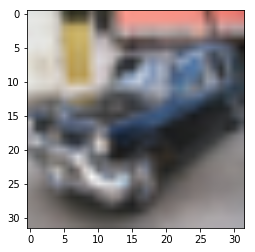

In [54]:
imgs, lbls = next(iter(dataloaders['train']))
imgs = imgs.to(device)
lbls = lbls.to(device)
print(imgs.shape)

import numpy as np
import matplotlib.pyplot as plt

idx = torch.randint(0, batch_size, size=(1,))
img = imgs[idx,...].squeeze(0)

img = np.moveaxis(img.cpu().numpy(), 0, -1)
img.shape

plt.imshow(img, interpolation='bilinear')

In [62]:
y = model(imgs)
y[idx,...]

model.base.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

# config 


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum=0.9)

# trainer

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    test_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history

In [36]:
model, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.2335 Acc: 0.9276
test Loss: 0.8158 Acc: 0.7503

Epoch 1/24
----------
train Loss: 0.2245 Acc: 0.9278
test Loss: 0.8326 Acc: 0.7519

Epoch 2/24
----------
train Loss: 0.2224 Acc: 0.9288
test Loss: 0.8445 Acc: 0.7522

Epoch 3/24
----------
train Loss: 0.2151 Acc: 0.9309
test Loss: 0.8607 Acc: 0.7519

Epoch 4/24
----------


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=RGB size=32x32 at 0x7FAD5998DB00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 585, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt


train Loss: 0.2150 Acc: 0.9306
test Loss: 0.8675 Acc: 0.7503

Epoch 5/24
----------


KeyboardInterrupt: ignored